<a href="https://colab.research.google.com/github/ZuckermanLab/CodingClass2025/blob/main/day5_coding_class_ml_and_ann.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PSI Coding Class: Machine Learning with Neural Networks

## Introduction to Machine Learning
**What is Machine Learning, and Why Should You Learn It?**

Machine learning is the science of teaching computers to find patterns and make predictions from data—just like how we learn from examples, but with the power to handle huge amounts of information. It is fun because you get to teach a computer to do something new and see it improve over time, and it is useful because machine learning is everywhere: in medicine, art, finance, and even helping scientists discover new things faster.

In this class, we will learn what machine learning is by building and training a neural network to do regression—a way to predict numbers from data—so you can see how it works in practice. We will learn together by doing, so you will leave this class with your first working machine learning model, and the confidence to keep exploring more on your own.

There are a few standard steps to machine learning:  
1. Preprocessing your data
2. Splitting the data into training and testing portions
3. Training the machine learning model
4. Evaluating the model's accuracy

We will walk through all of these steps together. We'll start by importing some python libraries so that we have the functions we need.

In [ ]:
!pip install gdown

In [ ]:
import gdown
import numpy as np
import pandas as pd

### Load the Data!
To train the model, we first need to obtain data and bring it into the python "environment" - the space that python has access to.  

We'll be working with some example data from a data set of [_multiplexed immunohistochemistry (mIHC)_](https://pmc.ncbi.nlm.nih.gov/articles/PMC7170662/). mIHC is a technique for getting a lot of information about the different proteins that individual cells are expressing. This data helps biomedical researchers and doctors learn what cell types are in a tissue sample from a patient, and it helps them to figure out different kinds of cancers or how well a patient's treatment is working.  

The data we will be using today looks a little like this when it is viewed as an image:  
![example mIHC](https://cdn.ncbi.nlm.nih.gov/pmc/blobs/5536/7170662/e99beed88e14/CAC2-40-135-g003.jpg)<sup>1</sup>

Each of the colors in this picture represents a different protein being measured with mIHC. if a pixel has a certain color, then it means that some amount of the protein was measured there. We then perform _[cell segmentation](https://www.sciencedirect.com/topics/computer-science/cell-segmentation)_ to see which pixels belong to each cell.

mIHC data is very large (the data we are using is over 500 MB!). We'll use a special python library called [`gdown`](https://pypi.org/project/gdown/) to download the data to the Google Colab "[runtime](https://research.google.com/colaboratory/local-runtimes.html)" and then use [`pandas`](https://pypi.org/project/pandas/) to load that data into the python "[environment](https://www.reddit.com/r/pythontips/comments/1exrhb9/what_is_a_python_environment_in_simple_terms/)." Let's load the data now.

In [ ]:
file_id = "1dViAJS4AwFzYYdfcXDqwZNm9UBUFhQmR"  # use the file ID for the public Google data set
output_file_name = "mihc_mean_intensity_data.csv"  # name for the file to save the data to
gdown.download(f"https://drive.google.com/uc?id={file_id}", output_file_name, quiet=False) # download the data!

Downloading...
From (original): https://drive.google.com/uc?id=1dViAJS4AwFzYYdfcXDqwZNm9UBUFhQmR
From (redirected): https://drive.google.com/uc?id=1dViAJS4AwFzYYdfcXDqwZNm9UBUFhQmR&confirm=t&uuid=d5feac1a-6263-4d05-8d8c-3d1273f307f1
To: /content/mihc_mean_intensity_data.csv
100%|██████████| 563M/563M [00:08<00:00, 62.7MB/s]


'mihc_mean_intensity_data.csv'

In [ ]:
  # bring the saved data into the python environment
  datafile = "mihc_mean_intensity_data.csv"
  data = pd.read_csv(datafile)

Let's take a look at the top part of the data using the `head()` function from `pandas`. Notice the names of the columns. Each column is the name of a different protein that was measured with mIHC. Each row is the amount of that protein measured from one cell.

In [ ]:
data.head()

,DNA,PD1,MHCII,CD206,CD45,CD11C,LY6G,GRZB,FOXP3,CC3,CD8,CD11B,CD3,LY6B2,F480,ASMA,KI67,PANCK
0,0.355294,0.012567,0.005253,0.003666,0.005381,0.014136,0.010670,0.035987,0.009394,0.022745,0.001642,0.038212,0.004943,0.003301,0.039015,0.248263,0.108837,0.056689
1,0.251264,0.002504,0.014198,0.003024,0.001914,0.014718,0.001488,0.029813,0.003071,0.000661,0.000969,0.009662,0.005410,0.009615,0.014883,0.275833,0.086133,0.054453
2,0.300036,0.006298,0.002139,0.012549,0.010671,0.023696,0.009222,0.010410,0.011432,0.003898,0.019370,0.021485,0.010125,0.008247,0.008675,0.326061,0.068925,0.057849
3,0.284706,0.002993,0.001631,0.000475,0.002848,0.012446,0.007203,0.012157,0.000702,0.002023,0.005325,0.089143,0.017172,0.006935,0.067554,0.193044,0.092508,0.065986
4,0.297536,0.003167,0.006637,0.010156,0.005380,0.024359,0.004198,0.033183,0.008321,0.002841,0.004902,0.085219,0.013550,0.005807,0.152288,0.177577,0.107416,0.060256


## The Regression Task
One of the proteins we measured in this mIHC experiment is [Ki67](https://en.wikipedia.org/wiki/Ki-67_(protein)). Ki67 is a signal we look for in cells to see if they are growing and dividing. But testing for every signal in every cell can take a lot of time and resources. If we can predict Ki67 by looking at other signals the cell has, we can figure out which cells are growing without extra tests. This helps us better understand how cells behave in tissues like tumors and can make research faster and easier.

Let's split the data into our target (Ki67) and the predictor variables now.

In [ ]:
# Split into X (features) and y (target)
target_column='KI67'
X = data.drop(columns=[target_column]).values
y = data[target_column].values.reshape(-1, 1)

### 1. Cleaning and Preparing Your Data (Preprocessing)



Before we teach our computer, we need to get our data ready by making the numbers comparable. Some protein measurements might be on very different scales (e.g., one is 0-10, another is 0-1000). We use techniques like scaling or standardizing to bring them to a similar range so no single measurement unfairly dominates. Think of it like making sure everyone's scores are out of 100 before comparing them. Figure 1 illustrates two types of preprocessing techniques used in machine learning.

![](https://github.com/emcramer/psicodinclass2025/blob/main/preprocess-data.png?raw=true)  
**Figure 1.** Standardization and Scaling for preprocessing data before training a machine learning algorithm.

Let's scale our data now to get it ready for the next step. We'll use the [`StandardScaler()`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) from sci-kit learn to do the standardization process for us.

In [ ]:
# import the necessary functions from scikit-learn
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# scale the data!

# step 1: make some objects to scale the data
standardizer_X = StandardScaler()
standardizer_y = StandardScaler()
minmaxer_x = MinMaxScaler()
minmaxer_y = MinMaxScaler()

# step 2: standardize the data
X_standard = standardizer_X.fit_transform(X)
y_standard = standardizer_y.fit_transform(y)

# step 3: scale the data to be between 0-1
X_scaled = minmaxer_x.fit_transform(X_standard)
y_scaled = standardizer_y.fit_transform(y_standard)

### 2. Splitting Your Data: Learning and Testing

We can't test our model on the exact data it learned from, or it will just memorize the answers! So, we split our data into three parts:

Training Set: This is the biggest chunk, which the computer "learns" from. It sees the protein measurements and their corresponding Ki67 values.

Validation Set: This is a smaller set used to fine-tune the model during the learning process. It's like a practice quiz to see if the computer is understanding things correctly.

Test Set: This is the untouched data used only at the very end to see how well the computer can predict Ki67 for completely new cells. This is the real exam!

![](https://raw.githubusercontent.com/emcramer/psicodinclass2025/refs/heads/main/data-split.png)  
**Figure 2.** Illustrating how we split our data set into training, testing, and validation sets. Each set has a different purpose: (1) train the machine learning model, (2) test the model's accuracy, (3) check how well the model performs while testing.

In [ ]:
# import the function we need to split the data into training and testing from
# scikit-learn
from sklearn.model_selection import train_test_split

# Split into train (80%), test (20%)
X_trainval, X_test, y_trainval, y_test = train_test_split(
    X_scaled, y_scaled, test_size=0.2, random_state=42
)

# Further split train into train (80%) and validation (20%)
X_train, X_val, y_train, y_val = train_test_split(
    X_trainval, y_trainval, test_size=0.2, random_state=42
)

**Double Check Data Types!!!**

We are planning to train a neural network using the [`pytorch`](https://pytorch.org/) package to predict the value of Ki67 from the rest of a cell's proteins. To use this package, we need to make sure that the data is in the correct [object type](https://bham-carpentries.github.io/2018-12-17-bham_python-novice-inflammation/02-variables/index.html). Pytorch expects a [tensor](https://docs.pytorch.org/tutorials/beginner/introyt/tensors_deeper_tutorial.html) data type, so that is what we will convert the data to.

In [ ]:
# import the pytorch library so we can convert the data to a pytorch data object (called a "tensor")
import torch

# Convert the X and y to the appropriate data type for PyTorch!
# Convert to torch tensors and make sure that the values are floats with 32 bits
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

### 3. Teaching the Computer (Training the Regression Model)

We use a type of machine learning called a regression model. This model tries to find a mathematical relationship between the other protein markers (A, B, C) and the Ki67 intensity.

Think of it like drawing a line (or a more complex curve) through a scatter plot of our data. The model adjusts its internal "rules" to make the best possible line that goes through as many of our training data points as possible. It's learning how changes in other proteins relate to changes in Ki67.

To help conceive of the training process visually, we can think of making a linear regression model. Watch the animation below. What happens to the line as we increase the number of training iterations? What happens to the slope and intercept (m and b)?

![](https://github.com/emcramer/psicodinclass2025/blob/main/regression_training_animation.gif?raw=true)

We are going to use a neural network to make this prediction, not linear regression. Before we train the network, let's do a deeper dive on how neural networks work.

### What is a Neural Network?
Neural networks are a type of algorithm designed to recognize patterns and make decisions. It's called a "neural network" because the basic building block of the algorithm, a "neuron," is inspired by how neurons in the human brain work.

Biological neurons have dendrites to receive input, a body for processing inputs (like a threshold for sodium levels), and an axon with terminal ends to pass along information.  

![](https://askabiologist.asu.edu/sites/default/files/resources/articles/neuron_anatomy.jpg)

Information moves from one neuron to the next in a network by getting passed from the first neuron's axon to the second neuron's dendrites.

In **artificial neural networks**, neurons can be modeled or represented as a sequence of mathematical functions. Each neuron has multiple inputs (dendrites) and an output that can connect to other neurons (axon terminals). The neuron multiplies each of its inputs by a specific weight and adds a fixed value called a bias, similar to point-slope formula for making a line in algebra. The sum of all the inputs is calculated, and then a special transformation called an "activation function" is used to convert the sum into a value between 0 and 1 (sort of like the signal processing that occurs in the body of a real-life neuron). The output can then be passed to the next layer of neurons in the network.

To build an artificial neural network, multiple neurons can be connected with the outputs of one neuron becoming the inputs of the next neuron. These connections are sort of like synapses between biological neurons in the brain.

Neurons can be connected in layers with different patterns that perform a sequence of mathematical operations on the input data. The structure of the layera and the order of the operations is what allows the network to learn how to find patterns in the data. The first layer of neurons that receives the data is the input layer. The last layer of neurons outputs the prediction of the network, so this is called the "output layer." The layers in-between the input and output layers are called "hidden layers." In this diagram, each circle is a neuron in the artificial neural network.

![](https://github.com/emcramer/psicodinclass2025/blob/main/neural-network-architecture.png?raw=true)

In a sense, neural networks are like doing linear regression over and over again, in small steps! By combining many linear regressions and using one regression's output for another regression's input, the neural network can approximate _non-linear relationships_ that are too complicated for the simple $y=mx+b$ formula.

For articial neural networks to make accurate predictions, they must be trained to find what the between combinations of weights and biases should be for each neuron in the network. The values of the weights and biases are usually found through "forward passes" and "backpropagation."

In the forward pass, input data is fed into the network, and the network calculates a prediction. The accuracy of that prediction is then check using a "loss function." Based on how accurate or inaccurate the prediction was, the weights and biases for each of the neurons are updated to a new value in a process called backpropagation. To get the most accurate predictions, the forward passes and backpropagation need to be repeated with A LOT of data.

Let's implement a neural network in pytorch and lean how to optimize it (make it the most accurate we can) now.

In [ ]:
# import the neural network module from pytorch!
import torch.nn as nn

# Make a simple neural network with pytorch - that's it!
# don't worry about the "class" keyword in python for now
class SimpleNN(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 1)
        )

    def forward(self, x):
        return self.model(x)

In [ ]:
# make a variable to hold the neural network
model = SimpleNN(input_dim=X_train_tensor.shape[1])

### Network Parameters
When we train a neural network, we have to tell it how to learn. Three important settings help with this:  
1. _Loss criterion_: This is like a score that tells the network how wrong its guesses are, so it knows what to fix.
2. _Epochs_: This is how many times the network goes through all the training data to practice and get better.
3. _Learning rate_: This controls how big the network’s changes are each time it learns, like deciding whether to take small careful steps or big fast steps when trying to improve.

By choosing these settings carefully, we help the neural network learn in a way that is accurate and efficient.

In [ ]:
# import the optimizer module from pytorch!
import torch.optim as optim

# Define parameters for the training step
criterion = nn.MSELoss() # MSE = mean squared error!
learning_rate = 0.001
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
epochs = 100

#### Train the Network!
Now that we have the network, its architecture or structure, and we set the parameters, it is time to train it to make predictions. The code below trains the neural network and checks how well it is learning over time. Here is a step by step for what it is doing.

1. Set up lists to keep track of training loss, validation loss, and weight sizes so we can see how they change as the model learns.

2. Repeat for each epoch (one full round of practice over all the training data):

        - Put the model in training mode so it can update itself.

        - Clear out old gradients so we start fresh.

        - Make predictions on the training data.

        - Calculate how wrong the predictions are using the loss criterion.

        - Calculate how to adjust the model to improve (backpropagation).

        - Update the model with these adjustments (optimizer step).

        - Record the current training loss to track progress.

3. Then, check how well the model does on validation data, which is data it hasn’t seen during training:

        - Put the model in evaluation mode so it does not update itself.

        - Make predictions on the validation data.

        - Calculate and record how wrong the predictions are on this validation data.

4. Record the size of the model’s weights to see how big they are getting, which helps monitor the model’s behavior.

5. Every 10 epochs, print out the training and validation losses so we can watch the model’s progress as it learns.

In simple terms:  
✨ This code teaches the model, checks how well it is learning, keeps track of its progress, and shows us updates as it improves over time.

In [ ]:
def train_model(model, X_train_tensor, y_train_tensor, X_val_tensor, y_val_tensor):
  train_losses = []
  val_losses = []
  weight_norms = []

  for epoch in range(epochs):
      model.train()
      optimizer.zero_grad()
      outputs = model(X_train_tensor)
      loss = criterion(outputs, y_train_tensor)
      loss.backward()
      optimizer.step()

      train_losses.append(loss.item())

      # Validation loss tracking
      model.eval()
      with torch.no_grad():
          val_outputs = model(X_val_tensor)
          val_loss = criterion(val_outputs, y_val_tensor)
          val_losses.append(val_loss.item())

          w = model.model[0].weight  # adjust layer index as needed
          norm = torch.norm(w).item()
          weight_norms.append(norm)

      if (epoch + 1) % 10 == 0:
          print(f"Epoch [{epoch+1}/{epochs}] Train Loss: {loss.item():.4f} | Val Loss: {val_loss.item():.4f}")
  return model, train_losses, val_losses, weight_norms

model, train_losses, val_losses, weight_norms = train_model(model, X_train_tensor, y_train_tensor, X_val_tensor, y_val_tensor)

Epoch [10/100] Train Loss: 1.0032 | Val Loss: 0.9981
Epoch [20/100] Train Loss: 0.9899 | Val Loss: 0.9847
Epoch [30/100] Train Loss: 0.9735 | Val Loss: 0.9680
Epoch [40/100] Train Loss: 0.9493 | Val Loss: 0.9426
Epoch [50/100] Train Loss: 0.9088 | Val Loss: 0.9004
Epoch [60/100] Train Loss: 0.8476 | Val Loss: 0.8372
Epoch [70/100] Train Loss: 0.7663 | Val Loss: 0.7553
Epoch [80/100] Train Loss: 0.6892 | Val Loss: 0.6828
Epoch [90/100] Train Loss: 0.6593 | Val Loss: 0.6574
Epoch [100/100] Train Loss: 0.6453 | Val Loss: 0.6442









### 4. Checking How Good It Is (Evaluating Accuracy)

Once the model is trained, we use the test set to see how well it predicts Ki67 for cells it's never seen before.

We compare the Ki67 values the model predicts with the actual Ki67 values in the test set.

Metrics like Mean Squared Error (MSE) or R-squared tell us how close the predictions are to the real values. A lower MSE or a higher R-squared means our model is doing a better job of predicting cell proliferation!


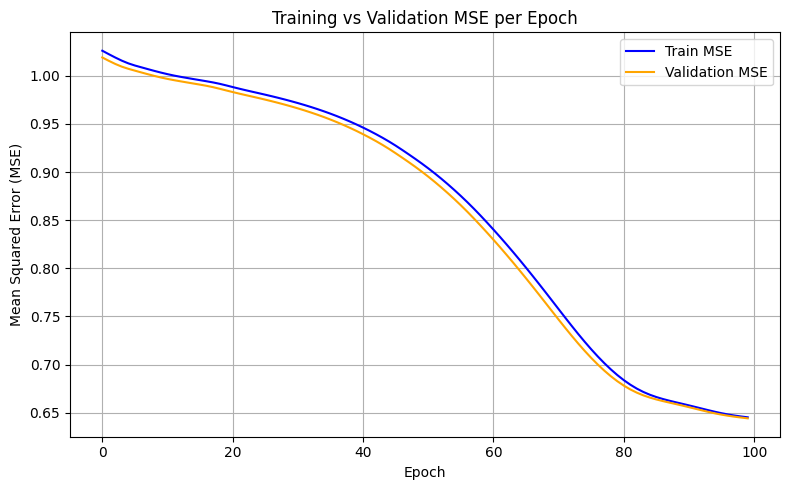

In [ ]:
# import matplotlib for plotting
import matplotlib.pyplot as plt

def plot_loss(train_losses, val_losses):
  # plot the mean squared error on the training and validation data sets
  plt.figure(figsize=(8, 5))
  plt.plot(train_losses, label='Train MSE', color='blue')
  plt.plot(val_losses, label='Validation MSE', color='orange')
  plt.xlabel('Epoch')
  plt.ylabel('Mean Squared Error (MSE)')
  plt.title('Training vs Validation MSE per Epoch')
  plt.legend()
  plt.grid(True)
  plt.tight_layout()
  plt.show()

plot_loss(train_losses, val_losses)

How **accurate** is our model? Let's write a function that takes the model we want to test and gives it the testing tensors to check its accuracy.

In [ ]:
def print_model_accuracy(model, X_test_tensor, y_test_tensor):
  model.eval()
  with torch.no_grad():
      test_outputs = model(X_test_tensor)
      test_loss = criterion(test_outputs, y_test_tensor)
      print(f"Final Test MSE: {test_loss.item():.4f}")
      return test_loss.item()

test_mse = print_model_accuracy(model, X_test_tensor, y_test_tensor)

Final Test MSE: 0.6415


The mean squared error is telling us that on average, our model prediction is off by the square root of that value.  
<img src="https://i0.wp.com/statisticsbyjim.com/wp-content/uploads/2017/04/residuals.png?w=684&ssl=1" width="240px"/>

Because the errors have been squared, the units have changed. If we want to know on average how much signal intensity is, then we need to take the square of the MSE, called the "Root Mean Squared Error" or RMSE.

In [ ]:
# print the RMSE!
print(f"On average, the model prediction was off by {np.round(np.sqrt(test_mse), 2)} units of protein intensity.")

On average, the model prediction was off by 0.8 units of protein intensity.


## Experimenting with Neural Networks!
Now that you're a neural network expert, try some of these exercises and see if you can make a more accurate model!  Don't get discouraged if you get stuck. Ask questions and don't be afraid to use chatGPT to help understand the code...

### Exercise \#1. What happens if you add more or less training epochs? (easy)

In [ ]:
# Define parameters for the training step
criterion = nn.MSELoss() # MSE = mean squared error!
learning_rate = 0.001
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


##### Uncomment and change this line!!
# epochs = _____

model, train_losses, val_losses, weight_norms = train_model(model, X_train_tensor, y_train_tensor, X_val_tensor, y_val_tensor)
plot_loss(train_losses, val_losses)
print_model_accuracy(model, X_test_tensor, y_test_tensor)

2. What happens if you change the learning rate? (medium)

In [ ]:
# Define parameters for the training step
criterion = nn.MSELoss() # MSE = mean squared error!

##### Uncomment and change this line!!
# learning_rate = ____

optimizer = optim.Adam(model.parameters(), lr=learning_rate)
epochs = 100

model, train_losses, val_losses, weight_norms = train_model(model, X_train_tensor, y_train_tensor, X_val_tensor, y_val_tensor)
plot_loss(train_losses, val_losses)
print_model_accuracy(model, X_test_tensor, y_test_tensor)

### Exercise \#3. What happens if you change the activation function? (medium)
PyTorch has a lot of different activation functions you can use such as `ReLu`, `Tanh`, and `Softmax`. You can see a list of them [here](https://docs.pytorch.org/docs/stable/nn.html#non-linear-activations-weighted-sum-nonlinearity). Try changing some and see what happens!

In [ ]:
class SimpleNN(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(), ## <- CHANGE ME!!
            nn.Linear(64, 32),
            nn.ReLU(), ## <- CHANGE ME!!
            nn.Linear(32, 16),
            nn.ReLU(), ## <- CHANGE ME!!
            nn.Linear(16, 1)
        )

    def forward(self, x):
        return self.model(x)

# make a variable to hold the neural network
model = SimpleNN(input_dim=X_train_tensor.shape[1])

# Define parameters for the training step
criterion = nn.MSELoss()
learning_rate = 0.001
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
epochs = 100

# train the model
model, train_losses, val_losses, weight_norms = train_model(model, X_train_tensor, y_train_tensor, X_val_tensor, y_val_tensor)

# plot how well the model performs
plot_loss(train_losses, val_losses)

# print the model's accuracy
print_model_accuracy(model, X_test_tensor, y_test_tensor)

### Exercise \#4. What happens if you change the size of the hidden layers in the network? (hard)
Try changing the sizes of the layers in the neural network. In PyTorch, the sizes must be multiples of two, and you specify the input and output sizes of a layer like this `nn.LINEAR(input_size, output_size)`. For example `nn.LINEAR(16,8)` makes a linearly connected layer for the neural network with an _input size_ of 16 neurons and an _output size_ of 8 neurons.

In [ ]:
class SimpleNN(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 64), ## <- CHANGE ME!!
            nn.ReLU(),
            nn.Linear(64, 32), ## <- CHANGE ME!!
            nn.ReLU(),
            nn.Linear(32, 16), ## <- CHANGE ME!!
            nn.ReLU(),
            nn.Linear(16, 1) ## <- CHANGE ME!!
        )

    def forward(self, x):
        return self.model(x)

# make a variable to hold the neural network
model = SimpleNN(input_dim=X_train_tensor.shape[1])

# Define parameters for the training step
criterion = nn.MSELoss()
learning_rate = 0.001
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
epochs = 100

# train the model
model, train_losses, val_losses, weight_norms = train_model(model, X_train_tensor, y_train_tensor, X_val_tensor, y_val_tensor)

# plot how well the model performs
plot_loss(train_losses, val_losses)

# print the model's accuracy
print_model_accuracy(model, X_test_tensor, y_test_tensor)

### Exercise \#5. What happens if you add a new hidden layer to the network? (harder)


In [ ]:
class SimpleNN(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 64), ## <- CHANGE ME!!
            nn.ReLU(),
            nn.Linear(64, 32), ## <- CHANGE ME!!
            nn.ReLU(),
            nn.Linear(32, 16), ## <- CHANGE ME!!
            nn.ReLU(),
            nn.Linear(16, 1) ## <- CHANGE ME!!
        )

    def forward(self, x):
        return self.model(x)

# make a variable to hold the neural network
model = SimpleNN(input_dim=X_train_tensor.shape[1])

# Define parameters for the training step
criterion = nn.MSELoss()
learning_rate = 0.001
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
epochs = 100

# train the model
model, train_losses, val_losses, weight_norms = train_model()

# plot how well the model performs
plot_loss(train_losses, val_losses)

# print the model's accuracy
print_model_accuracy(model, X_test_tensor, y_test_tensor)

### Exercise \#6. Add "early stopping"
Early stopping is a method to end the training cycle when the network's accuracy is not increasing very much (or even getting worse!). This prevents the model from over fitting to the data and saves time and resources. How does this change the network's accuracy on the test data? (super hard)

This is a hard one to do after just one week of coding! You'll need to change the `train_model()` function.

In [ ]:
#### CHANGE THIS FUNCTION TO ADD EARLY STOPPING!!
def train_model_with_early_stopping(model, X_train_tensor, y_train_tensor, X_val_tensor, y_val_tensor):
  train_losses = []
  val_losses = []
  weight_norms = []

  for epoch in range(epochs):
      model.train()
      optimizer.zero_grad()
      outputs = model(X_train_tensor)
      loss = criterion(outputs, y_train_tensor)
      loss.backward()
      optimizer.step()

      train_losses.append(loss.item())

      # Validation loss tracking
      model.eval()
      with torch.no_grad():
          val_outputs = model(X_val_tensor)
          val_loss = criterion(val_outputs, y_val_tensor)
          val_losses.append(val_loss.item())

          w = model.model[0].weight  # adjust layer index as needed
          norm = torch.norm(w).item()
          weight_norms.append(norm)

      if (epoch + 1) % 10 == 0:
          print(f"Epoch [{epoch+1}/{epochs}] Train Loss: {loss.item():.4f} | Val Loss: {val_loss.item():.4f}")

      ##### ADD EARLY STOPPING TO THE FUNCTION
      # stop training the model if the training loss during the latest epoch is
      # greater than the training loss of the previous epoch
      # if _____:
      #  print("Early stopping")
      #  return model, train_losses, val_losses, weight_norms

  return model, train_losses, val_losses, weight_norms

class SimpleNN(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 1)
        )

    def forward(self, x):
        return self.model(x)

# make a variable to hold the neural network
model = SimpleNN(input_dim=X_train_tensor.shape[1])

# Define parameters for the training step
criterion = nn.MSELoss()
learning_rate = 0.001
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
epochs = 100

# train the model
model, train_losses, val_losses, weight_norms = train_model_with_early_stopping(model, X_train_tensor, y_train_tensor, X_val_tensor, y_val_tensor)

# plot how well the model performs
plot_loss(train_losses, val_losses)

# print the model's accuracy
print_model_accuracy(model, X_test_tensor, y_test_tensor)

## References
[1] Tan WCC, Nerurkar SN, Cai HY, Ng HHM, Wu D, Wee YTF, Lim JCT, Yeong J, Lim TKH. Overview of multiplex immunohistochemistry/immunofluorescence techniques in the era of cancer immunotherapy. Cancer Commun (Lond). 2020 Apr;40(4):135-153. doi: 10.1002/cac2.12023. Epub 2020 Apr 17. PMID: 32301585; PMCID: PMC7170662.  
[2] Goodfellow, I., Bengio, Y., & Courville, A. (2016). Deep Learning. MIT Press. http://www.deeplearningbook.org